# Deep Learning with PyTorch : Build a Generative Adversarial Network 

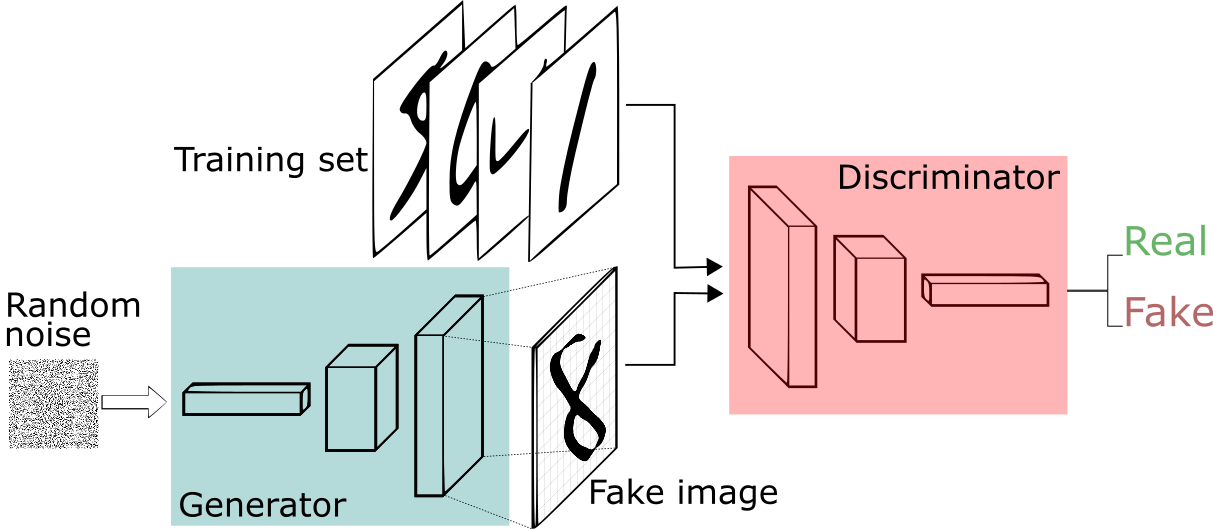

In [44]:
import torch 
torch.manual_seed(42)
import numpy as np 
import matplotlib.pyplot as plt 

from tqdm.notebook import tqdm

# Configurations

In [45]:
device = 'cuda' # image = image.to(device)
batch_size = 128 # trainloader, training loop
noise_dim = 64 #noise dim for generator

#optimizer parameters
lr = 0.0002
beta_1 = 0.5 #for Adam optimizer
beta_2 = 0.99 #for Adam optimizer

#training variables
epochs = 20


# Load MNIST Dataset 

In [46]:
from torchvision import datasets, transforms as T

In [47]:
train_augs = T.Compose([
                        T.RandomRotation((-20,+20)),
                        T.ToTensor() # (h,w,c) -> (c,h,w), to make sure numpy to pytorch tensor
])

In [49]:
trainset = datasets.MNIST('MNITS/',download=True, train=True, transform=train_augs)

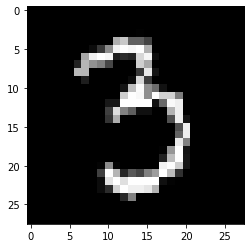

In [50]:
image, label = trainset[50]
plt.imshow(image.squeeze(), cmap='gray')

In [51]:
print('total images present in trainset are', len(trainset))

total images present in trainset are 60000


# Load Dataset Into Batches 

In [52]:
from torch.utils.data import DataLoader
from torchvision.utils import make_grid

In [53]:
trainloader = DataLoader(trainset, batch_size=batch_size, shuffle=True)

In [54]:
print('Total number of batches in trainloader: ', len(trainloader))

Total number of batches in trainloader:  469


In [55]:
dataiter = iter(trainloader)
images, _ = dataiter.next()
print(images.shape)

torch.Size([128, 1, 28, 28])


In [56]:
# 'show_tensor_images' : function is used to plot some of images from the batch

def show_tensor_images(tensor_img, num_images = 16, size=(1, 28, 28)):
    unflat_img = tensor_img.detach().cpu()
    img_grid = make_grid(unflat_img[:num_images], nrow=4)
    plt.imshow(img_grid.permute(1, 2, 0).squeeze())
    plt.show()

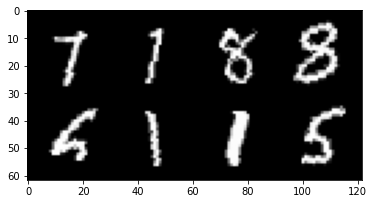

In [57]:
show_tensor_images(images, num_images=8)

# Create Discriminator Network 

In [58]:
#In case if torch summary is not installed 

!pip install torchsummary

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [59]:
from torch import nn
from torchsummary import summary

In [ ]:
'''

Network : Discriminator

input : (bs, 1, 28, 28)
      |                                                                                               ---- SUMMARY ----
      V
Conv2d( in_channels = 1, out_channels = 16, kernel_size = (3,3), stride = 2)                           #(bs, 16, 13, 13)
BatchNorm2d()                                                                                          #(bs, 16, 13, 13)
LeakyReLU()                                                                                            #(bs, 16, 13, 13)
      |
      V
Conv2d( in_channels = 16, out_channels = 32, kernel_size = (5,5), stride = 2)                          #(bs, 32, 5, 5)
BatchNorm2d()                                                                                          #(bs, 32, 5, 5)
LeakyReLU()                                                                                            #(bs, 32, 5, 5)
      |
      V
Conv2d( in_channels = 32, out_channels = 64, kernel_size = (5,5), stride = 2)                          #(bs, 64, 1, 1)
BatchNorm2d()                                                                                          #(bs, 64, 1, 1)
LeakyReLU()                                                                                            #(bs, 64, 1, 1)
      |
      V
Flatten()                                                                                              #(bs, 64)
Linear(in_features = 64, out_features = 1)                                                             #(bs, 1)

'''

In [60]:
def get_disc_block(in_channels, out_channels, kernel_size, stride):
  return nn.Sequential(
      nn.Conv2d(in_channels, out_channels, kernel_size, stride),
      nn.BatchNorm2d(out_channels),
      nn.LeakyReLU(0.2)
  )

In [92]:
class Discriminator(nn.Module):
  def __init__(self):
      super(Discriminator, self).__init__()

      self.block_1 = get_disc_block(1, 16, (3,3), 2)
      self.block_2 = get_disc_block(16, 32, (5,5), 2)
      self.block_3 = get_disc_block(32, 64, (5,5), 2)

      self.flatten = nn.Flatten()
      self.linear = nn.Linear(in_features=64, out_features=1)

  def forward(self,images):

    x1 = self.block_1(images)
    x2 = self.block_2(x1)
    x3 = self.block_3(x2)

    x4 = self.flatten(x3)
    x5 = self.linear(x4)

    return x5

In [94]:
D = Discriminator()
D.to(device)

Discriminator(
  (block_1): Sequential(
    (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(2, 2))
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.2)
  )
  (block_2): Sequential(
    (0): Conv2d(16, 32, kernel_size=(5, 5), stride=(2, 2))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.2)
  )
  (block_3): Sequential(
    (0): Conv2d(32, 64, kernel_size=(5, 5), stride=(2, 2))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.2)
  )
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear): Linear(in_features=64, out_features=1, bias=True)
)

# Create Generator Network 

In [ ]:
'''

Network : Generator 

z_dim = 64
input : (bs,z_dim)

      |
      | Reshape
      V

input : (bs, channel, height, width) -> (bs, z_dim , 1 , 1) 
      |                                                                                               ---- SUMMARY ----
      V
ConvTranspose2d( in_channels = z_dim, out_channels = 256, kernel_size = (3,3), stride = 2)             #(bs, 256, 3, 3)
BatchNorm2d()                                                                                          #(bs, 256, 3, 3)
ReLU()                                                                                                 #(bs, 256, 3, 3)
      |
      V
ConvTranspose2d( in_channels = 256, out_channels = 128, kernel_size = (4,4), stride = 1)               #(bs, 128, 6, 6)
BatchNorm2d()                                                                                          #(bs, 128, 6, 6)
ReLU()                                                                                                 #(bs, 128, 6, 6)
      |
      V
ConvTranspose2d( in_channels = 128, out_channels = 64, kernel_size = (3,3), stride = 2)                #(bs, 64, 13, 13)
BatchNorm2d()                                                                                          #(bs, 64, 13, 13)
ReLU()                                                                                                 #(bs, 64, 13, 13)
      |
      V
ConvTranspose2d( in_channels = 64, out_channels = 1, kernel_size = (4,4), stride = 2)                  #(bs, 1, 28, 28)
Tanh()                                                                                                 #(bs, 1, 28, 28)

'''

In [96]:
def get_gen_block(in_channels, out_channels, kernel_size, stride, final_block = False):
  if final_block == True:
    return nn.Sequential(
        nn.ConvTranspose2d(in_channels, out_channels, kernel_size, stride),
        nn.Tanh()
    )
  return nn.Sequential(
      nn.ConvTranspose2d(in_channels, out_channels, kernel_size, stride),
      nn.BatchNorm2d(out_channels),
      nn.ReLU()
  )

In [97]:
class Generator(nn.Module):

  def __init__(self, noise_dim):
    super(Generator,self).__init__()

    self.noise_dim = noise_dim
    self.block_1 = get_gen_block(noise_dim, 256, (3,3), 2)
    self.block_2 = get_gen_block(256, 128, (4,4), 1)
    self.block_3 = get_gen_block(128, 64, (3,3), 2)

    self.block_4 = get_gen_block(64, 1, (4,4), 2, final_block=True)

  def forward(self, r_noise_vec):

    #(bs, noise_dim) --> (bs, noise_dim, 1, 1)
    x = r_noise_vec.view(-1, self.noise_dim, 1, 1)

    x1 = self.block_1(x)
    x2 = self.block_2(x1)
    x3 = self.block_3(x2)
    x4 = self.block_4(x3)

    return x4



In [98]:
G = Generator(noise_dim)
G.to(device)

Generator(
  (block_1): Sequential(
    (0): ConvTranspose2d(64, 256, kernel_size=(3, 3), stride=(2, 2))
    (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (block_2): Sequential(
    (0): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (block_3): Sequential(
    (0): ConvTranspose2d(128, 64, kernel_size=(3, 3), stride=(2, 2))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (block_4): Sequential(
    (0): ConvTranspose2d(64, 1, kernel_size=(4, 4), stride=(2, 2))
    (1): Tanh()
  )
)

In [99]:
# Replace Random initialized weights to Normal weights  

def weights_init(m):  
    if isinstance(m, nn.Conv2d) or isinstance(m, nn.ConvTranspose2d):
        nn.init.normal_(m.weight, 0.0, 0.02)
    if isinstance(m, nn.BatchNorm2d):
        nn.init.normal_(m.weight, 0.0, 0.02)
        nn.init.constant_(m.bias, 0)

In [100]:
D = D.apply(weights_init)
G = G.apply(weights_init)

# Create Loss Function and Load Optimizer

In [104]:
def real_loss(disc_pred):
  criterion = nn.BCEWithLogitsLoss()
  ground_truth = torch.ones_like(disc_pred)
  loss = criterion(disc_pred, ground_truth)
  return loss

def fake_loss(disc_pred):
  criterion = nn.BCEWithLogitsLoss()
  ground_truth = torch.zeros_like(disc_pred)
  loss = criterion(disc_pred, ground_truth)
  return loss

In [105]:
D_opt = torch.optim.Adam(D.parameters(), lr = lr, betas = (beta_1,beta_2))
G_opt = torch.optim.Adam(G.parameters(), lr = lr, betas = (beta_1,beta_2))

# Training Loop 

  0%|          | 0/469 [00:00<?, ?it/s]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch : 1 | D_loss : 0.6731973043891158 | G_loss : 0.7169970784868512


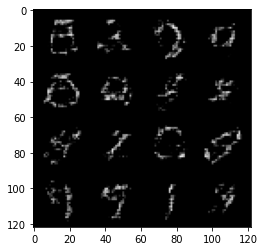

  0%|          | 0/469 [00:00<?, ?it/s]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch : 2 | D_loss : 0.6121080442786471 | G_loss : 0.7853334407562386


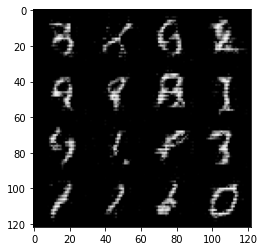

  0%|          | 0/469 [00:00<?, ?it/s]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch : 3 | D_loss : 0.5605820783419904 | G_loss : 0.8574807329981058


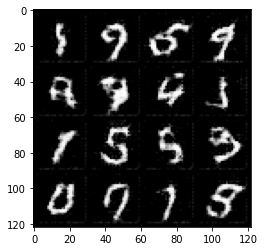

  0%|          | 0/469 [00:00<?, ?it/s]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch : 4 | D_loss : 0.5384083784211164 | G_loss : 0.9075705941552038


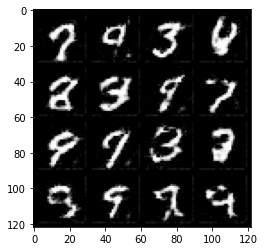

  0%|          | 0/469 [00:00<?, ?it/s]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch : 5 | D_loss : 0.5376925247945765 | G_loss : 0.932397633981603


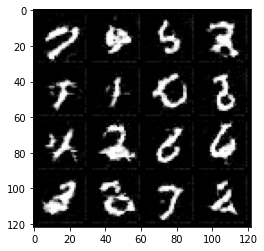

  0%|          | 0/469 [00:00<?, ?it/s]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch : 6 | D_loss : 0.5519655434561691 | G_loss : 0.9277373146909133


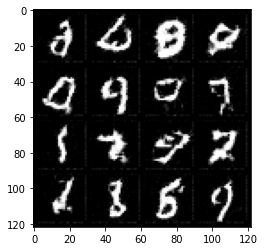

  0%|          | 0/469 [00:00<?, ?it/s]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch : 7 | D_loss : 0.5668327401695984 | G_loss : 0.9142115086888962


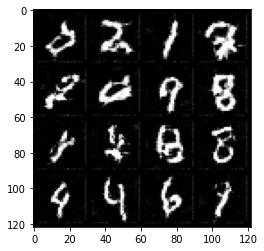

  0%|          | 0/469 [00:00<?, ?it/s]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch : 8 | D_loss : 0.5820424850307294 | G_loss : 0.904145354401074


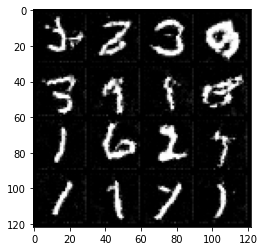

  0%|          | 0/469 [00:00<?, ?it/s]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch : 9 | D_loss : 0.5916287552064924 | G_loss : 0.8964892787211485


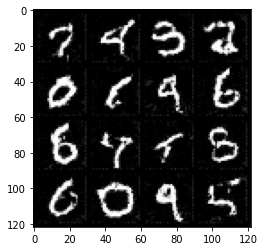

  0%|          | 0/469 [00:00<?, ?it/s]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch : 10 | D_loss : 0.5981597045083036 | G_loss : 0.8896879791450907


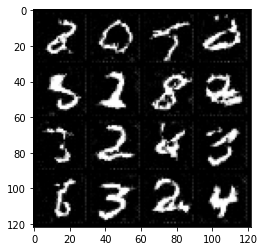

  0%|          | 0/469 [00:00<?, ?it/s]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch : 11 | D_loss : 0.6047732343297523 | G_loss : 0.8827901519437843


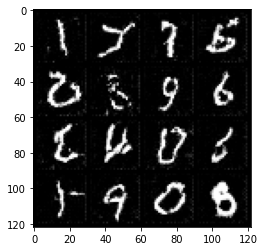

  0%|          | 0/469 [00:00<?, ?it/s]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch : 12 | D_loss : 0.6096439417491335 | G_loss : 0.8782310255809125


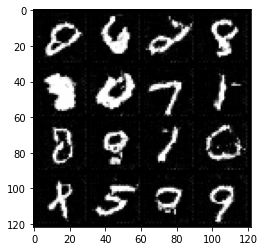

  0%|          | 0/469 [00:00<?, ?it/s]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch : 13 | D_loss : 0.613874809955483 | G_loss : 0.874435358845603


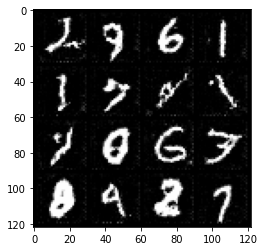

  0%|          | 0/469 [00:00<?, ?it/s]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch : 14 | D_loss : 0.6145296869501631 | G_loss : 0.8721662886869679


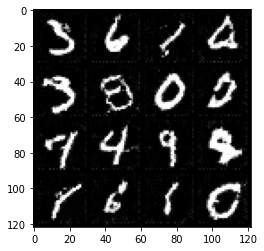

  0%|          | 0/469 [00:00<?, ?it/s]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch : 15 | D_loss : 0.6191649069664067 | G_loss : 0.86773730887533


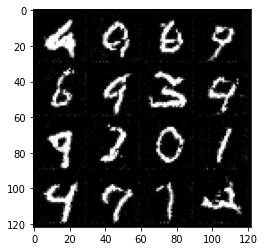

  0%|          | 0/469 [00:00<?, ?it/s]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch : 16 | D_loss : 0.621412959688508 | G_loss : 0.8647990522862498


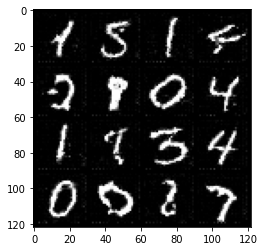

  0%|          | 0/469 [00:00<?, ?it/s]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch : 17 | D_loss : 0.6222746547605438 | G_loss : 0.8627685183909402


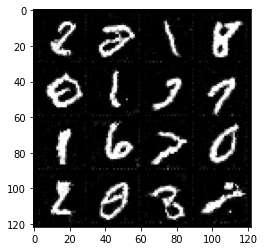

  0%|          | 0/469 [00:00<?, ?it/s]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch : 18 | D_loss : 0.6232894314631724 | G_loss : 0.8621437320831233


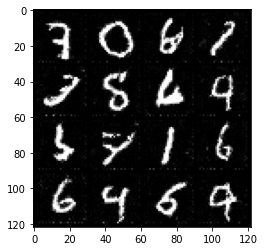

  0%|          | 0/469 [00:00<?, ?it/s]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch : 19 | D_loss : 0.6246498158491497 | G_loss : 0.8598366717794048


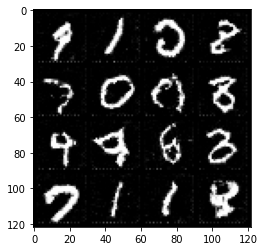

  0%|          | 0/469 [00:00<?, ?it/s]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch : 20 | D_loss : 0.6240189278812043 | G_loss : 0.8623675086350837


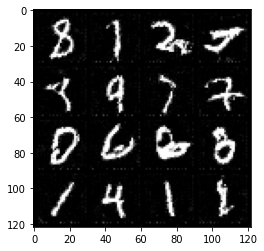

In [107]:
for i in range(epochs):

  total_d_loss = 0.0
  total_g_loss = 0.0

  for real_img, _ in tqdm(trainloader):

    real_img = real_img.to(device)
    noise = torch.randn(batch_size, noise_dim, device=device)

    #find loss and update weights for D

    D_opt.zero_grad()

    fake_img = G(noise)
    D_pred = D(fake_img)
    D_fake_loss = fake_loss(D_pred)

    D_pred = D(real_img)
    D_real_loss = real_loss(D_pred)

    D_loss = (D_fake_loss + D_real_loss)/2

    total_d_loss += D_loss.item()

    D_loss.backward()
    D_opt.step()

    #find loss and update weights for G

    G_opt.zero_grad()

    noise = torch.randn(batch_size, noise_dim, device=device)

    fake_img = G(noise)
    D_pred = D(fake_img)
    G_loss = real_loss(D_pred)

    total_g_loss += G_loss.item()

    G_loss.backward()
    G_opt.step()
  
  avg_d_loss = total_d_loss/len(trainloader)
  avg_g_loss = total_g_loss/len(trainloader)

  print('Epoch : {} | D_loss : {} | G_loss : {}'.format(i+1, avg_d_loss, avg_g_loss))

  show_tensor_images(fake_img)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


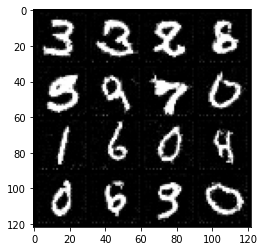

In [108]:
# Run after training is completed.
# Now you can use Generator Network to generate handwritten images

noise = torch.randn(batch_size, noise_dim, device = device)
generated_image = G(noise)

show_tensor_images(generated_image)